In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from sklearn.linear_model import LinearRegression

/Users/ajayrangan/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
data = pd.read_csv('csv-files/merged_df.csv')
data.columns = ['ZIPCODE','MENTAL HEALTH CALLS','TREES', 'LIQUOR_SHOPS', 'SMOKE_SHOPS',
           'SOLAR_ROOF_POTENTIAL', 'RESTAURANTS', 'AVG_SIDEWALK_WIDTH',
           'SIDEWALK CONDITION COMPLAINTS', 'STREET LIGHT CONDITION COMPLAINTS',
           'AVG_HEIGHT','POPULATION']
data.head()

,ZIPCODE,MENTAL HEALTH CALLS,TREES,LIQUOR_SHOPS,SMOKE_SHOPS,SOLAR_ROOF_POTENTIAL,RESTAURANTS,AVG_SIDEWALK_WIDTH,SIDEWALK CONDITION COMPLAINTS,STREET LIGHT CONDITION COMPLAINTS,AVG_HEIGHT,POPULATION
0,10001,1.594939,-0.693092,1.030044,1.615201,-0.739393,0.949560,0.869223,-0.231860,-0.457869,0.871854,44826.0
1,10002,0.525973,-0.857512,-0.122022,0.009141,-0.458616,0.037679,-0.163255,-0.196765,-0.249181,0.185881,162610.0
2,10003,0.721431,-0.749747,0.175600,0.415711,-0.731775,0.323531,1.692033,-0.377904,-0.414114,0.296637,111756.0
3,10004,-1.195468,-1.042264,9.270756,2.410201,-1.103657,12.673172,-1.455277,5.083505,3.965994,5.231510,17496.0
4,10005,0.662077,-0.987316,-0.491307,0.924666,-1.166130,0.069885,1.211890,1.275268,0.107473,4.473739,16214.0


In [3]:
data.shape

(183, 12)

<AxesSubplot:>

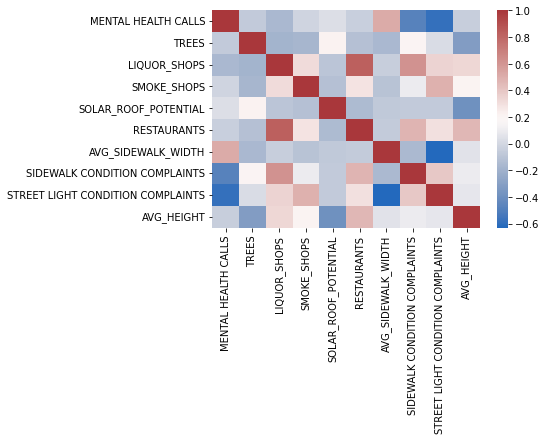

In [4]:
sns.heatmap(data.iloc[:,1:-1].corr(),cmap="vlag")

In [5]:
nyc_zip = gpd.read_file("ZIP_CODE_040114.shp")
nyc_zip = gpd.GeoDataFrame(nyc_zip[['ZIPCODE','COUNTY','geometry']],geometry='geometry')
nyc_zip['ZIPCODE'] = nyc_zip['ZIPCODE'].astype('int')
data2 = nyc_zip.merge(data,on='ZIPCODE',how='inner')
data2.head()

,ZIPCODE,COUNTY,geometry,MENTAL HEALTH CALLS,TREES,LIQUOR_SHOPS,SMOKE_SHOPS,SOLAR_ROOF_POTENTIAL,RESTAURANTS,AVG_SIDEWALK_WIDTH,SIDEWALK CONDITION COMPLAINTS,STREET LIGHT CONDITION COMPLAINTS,AVG_HEIGHT,POPULATION
0,11436,Queens,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",0.007930,0.440949,-0.315802,-0.502327,-0.727835,-0.220954,0.104341,-0.350119,0.136808,-0.489149,37362.0
1,11213,Kings,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",0.456697,-0.463521,-0.106314,-0.238814,-0.062102,-0.205377,0.920114,-0.546079,-0.103489,-0.344196,124852.0
2,11212,Kings,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",0.592825,-0.571031,-0.049903,0.139934,0.551089,-0.219563,0.957844,-0.634782,-0.183968,-0.408679,167732.0
3,11225,Kings,"POLYGON ((995908.365 183617.613, 996522.848 18...",0.166442,-0.563351,-0.138867,-0.087561,-0.262870,-0.156555,0.718125,1.108425,-0.220903,-0.341929,113054.0
4,11218,Kings,"POLYGON ((991997.113 176307.496, 992042.798 17...",-0.427282,-0.349759,-0.290212,-0.153932,0.878063,-0.183642,0.309562,-0.558112,-0.347925,-0.396315,144560.0


In [6]:
data2.shape

(196, 14)

In [7]:
data2['LONGITUDE'] = data2['geometry'].centroid.x
data2['LATITUDE'] = data2['geometry'].centroid.y

In [8]:
temp = data2.groupby('ZIPCODE').agg({'LONGITUDE':'mean','LATITUDE':'mean'})

In [9]:
data2 = data2.drop_duplicates('ZIPCODE')
data2['LONGITUDE'] = list(temp['LONGITUDE'])
data2['LATITUDE'] = list(temp['LATITUDE'])
data2.head()
data3 = data2.copy()

In [10]:
coords = data2[['LONGITUDE', 'LATITUDE']].values
distances = np.sqrt(np.sum((coords[:, None, :] - coords[None, :, :]) ** 2, axis=-1))
kernel = 'gaussian'
bandwidth = 50000
weights = np.exp(-distances ** 2 / (2 * bandwidth ** 2))
weights

array([[1.        , 0.96778538, 0.99018799, ..., 0.38279782, 0.32056634,
        0.33508482],
       [0.96778538, 1.        , 0.99324505, ..., 0.50562899, 0.4476569 ,
        0.47299734],
       [0.99018799, 0.99324505, 1.        , ..., 0.45265211, 0.38994691,
        0.40837411],
       ...,
       [0.38279782, 0.50562899, 0.45265211, ..., 1.        , 0.95837444,
        0.82683269],
       [0.32056634, 0.4476569 , 0.38994691, ..., 0.95837444, 1.        ,
        0.93469092],
       [0.33508482, 0.47299734, 0.40837411, ..., 0.82683269, 0.93469092,
        1.        ]])

<b> MANHATTAN

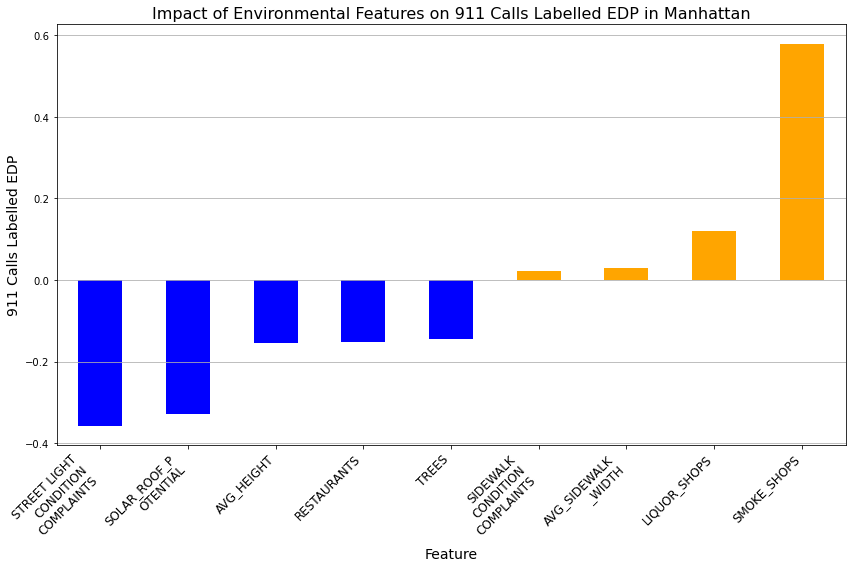

0.7239476891876356
                             feature  coefficient
7  STREET LIGHT CONDITION COMPLAINTS    -0.358140
3               SOLAR_ROOF_POTENTIAL    -0.328967
8                         AVG_HEIGHT    -0.155643
4                        RESTAURANTS    -0.151101
0                              TREES    -0.145468
6      SIDEWALK CONDITION COMPLAINTS     0.022996
5                 AVG_SIDEWALK_WIDTH     0.028836
1                       LIQUOR_SHOPS     0.119910
2                        SMOKE_SHOPS     0.579925


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


data2 = data3[data3['COUNTY'] == "New York"]

X = data2[['TREES', 'LIQUOR_SHOPS', 'SMOKE_SHOPS',
           'SOLAR_ROOF_POTENTIAL', 'RESTAURANTS', 'AVG_SIDEWALK_WIDTH',
           'SIDEWALK CONDITION COMPLAINTS', 'STREET LIGHT CONDITION COMPLAINTS',
           'AVG_HEIGHT']]

y = data2['MENTAL HEALTH CALLS']

model = LinearRegression()
model.fit(X, y)

# create a dataframe of feature coefficients
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}).sort_values('coefficient')
df.columns = df.columns.str.replace('_NORMALIZED', '').str.replace('NORMALIZED_', '')

# create a color map where negative values are blue and positive values are orange
colors = np.where(df['coefficient']>=0, 'orange', 'blue')

# create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(12, 8))

# create a bar plot of the coefficients
df.plot(x='feature', y='coefficient', kind='bar', color=colors, ax=ax, legend=False)

# set the axis labels and title, increase font size for readability
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('911 Calls Labelled EDP', fontsize=14)
ax.set_title('Impact of Environmental Features on 911 Calls Labelled EDP in Manhattan', fontsize=16)

# wrap the x-axis tick labels
labels = [textwrap.fill(label, width=12) for label in df['feature']]
# set the x-axis tick labels
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12, linespacing=1.2)

# remove the top and right spines
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

# add a horizontal grid to the plot
ax.yaxis.grid(True)

# display the plot and save as an image file
plt.tight_layout()
plt.savefig('Correlation between Build Environment Features on 911 Calls Labelled EDP in Manhattan', dpi=300)
plt.show()

# print the R-squared score
print(model.score(X,y))

df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}).sort_values('coefficient')
df.columns = df.columns.str.replace('_NORMALIZED', '').str.replace('NORMALIZED_', '')

# save the dataframe as a CSV file
df.to_csv('coefficients.csv', index=False)

# display the dataframe
print(df)

<b>NO MANHATTAN

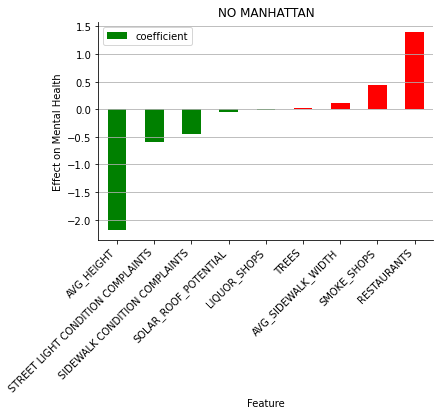

0.7141598849984827


<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


data2 = data3[data3['COUNTY'] != "New York"]

X = data2[['TREES', 'LIQUOR_SHOPS', 'SMOKE_SHOPS',
           'SOLAR_ROOF_POTENTIAL', 'RESTAURANTS', 'AVG_SIDEWALK_WIDTH',
           'SIDEWALK CONDITION COMPLAINTS', 'STREET LIGHT CONDITION COMPLAINTS',
           'AVG_HEIGHT']]

y = data2['MENTAL HEALTH CALLS']

model = LinearRegression()
model.fit(X, y\
          #, sample_weight=weights\
         )

# create a dataframe of feature coefficients
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}).sort_values('coefficient')
df.columns = df.columns.str.replace('_NORMALIZED', '').str.replace('NORMALIZED_', '')

# create a color map where negative values are green and positive values are red
colors = np.where(df['coefficient']>=0, 'red', 'green')

# create a bar plot of the coefficients
ax = df.plot(x='feature', y='coefficient', kind='bar', color=colors)

# set the axis labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Effect on Mental Health')
ax.set_title('Feature Coefficients')

# rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add a horizontal grid to the plot
ax.yaxis.grid(True)
plt.title('NO MANHATTAN')
# display the plot
plt.show()
plt.savefig('NO MANHATTAN.jpg')
print(model.score(X,y))

<b> ALL BOROUGHS

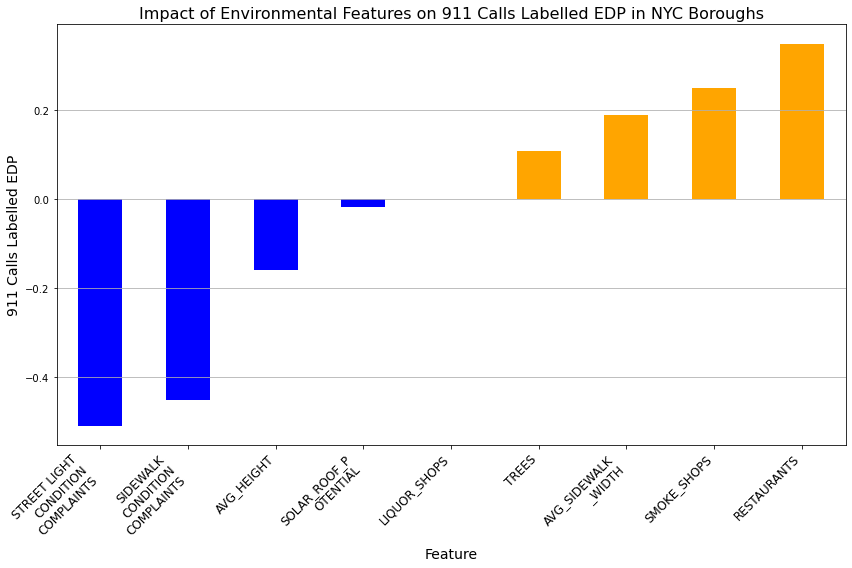

0.5941414793730226
                             feature  coefficient
7  STREET LIGHT CONDITION COMPLAINTS    -0.509059
6      SIDEWALK CONDITION COMPLAINTS    -0.451355
8                         AVG_HEIGHT    -0.159397
3               SOLAR_ROOF_POTENTIAL    -0.018215
1                       LIQUOR_SHOPS     0.000898
0                              TREES     0.108725
5                 AVG_SIDEWALK_WIDTH     0.189653
2                        SMOKE_SHOPS     0.249057
4                        RESTAURANTS     0.349620


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import textwrap

data2 = data3

X = data2[['TREES', 'LIQUOR_SHOPS', 'SMOKE_SHOPS',
           'SOLAR_ROOF_POTENTIAL', 'RESTAURANTS', 'AVG_SIDEWALK_WIDTH',
           'SIDEWALK CONDITION COMPLAINTS', 'STREET LIGHT CONDITION COMPLAINTS',
           'AVG_HEIGHT']]

y = data2['MENTAL HEALTH CALLS']

model = LinearRegression()
model.fit(X, y)

# create a dataframe of feature coefficients
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}).sort_values('coefficient')
df.columns = df.columns.str.replace('_NORMALIZED', '').str.replace('NORMALIZED_', '')

# create a color map where negative values are blue and positive values are orange
colors = np.where(df['coefficient']>=0, 'orange', 'blue')

# create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(12, 8))

# create a bar plot of the coefficients
df.plot(x='feature', y='coefficient', kind='bar', color=colors, ax=ax, legend=False)

# set the axis labels and title, increase font size for readability
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('911 Calls Labelled EDP', fontsize=14)
ax.set_title('Impact of Environmental Features on 911 Calls Labelled EDP in NYC Boroughs', fontsize=16)

# wrap the x-axis tick labels
labels = [textwrap.fill(label, width=12) for label in df['feature']]
# set the x-axis tick labels
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12, linespacing=1.2)

# remove the top and right spines
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

# add a horizontal grid to the plot
ax.yaxis.grid(True)

# display the plot and save as an image file
plt.tight_layout()
plt.savefig('Correlation between Build Environment Features on 911 Calls Labelled EDP in NYC.jpg', dpi=300)
plt.show()

# print the R-squared score
print(model.score(X,y))

df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}).sort_values('coefficient')
df.columns = df.columns.str.replace('_NORMALIZED', '').str.replace('NORMALIZED_', '')

# save the dataframe as a CSV file
df.to_csv('coefficients.csv', index=False)

# display the dataframe
print(df)

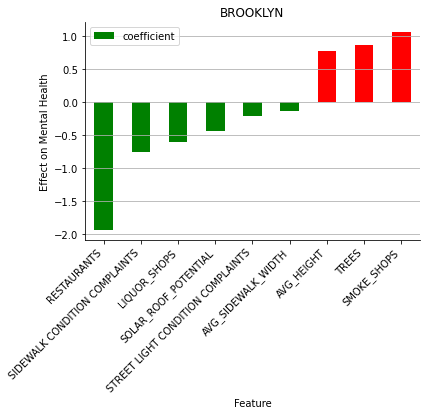

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


data2 = data3[data3['COUNTY'] == "Kings"]

X = data2[['TREES', 'LIQUOR_SHOPS', 'SMOKE_SHOPS',
           'SOLAR_ROOF_POTENTIAL', 'RESTAURANTS', 'AVG_SIDEWALK_WIDTH',
           'SIDEWALK CONDITION COMPLAINTS', 'STREET LIGHT CONDITION COMPLAINTS',
           'AVG_HEIGHT']]

y = data2['MENTAL HEALTH CALLS']

model = LinearRegression()
model.fit(X, y\
          #, sample_weight=weights\
         )

# create a dataframe of feature coefficients
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}).sort_values('coefficient')
df.columns = df.columns.str.replace('_NORMALIZED', '').str.replace('NORMALIZED_', '')

# create a color map where negative values are green and positive values are red
colors = np.where(df['coefficient']>=0, 'red', 'green')

# create a bar plot of the coefficients
ax = df.plot(x='feature', y='coefficient', kind='bar', color=colors)

# set the axis labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Effect on Mental Health')
ax.set_title('Feature Coefficients')

# rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add a horizontal grid to the plot
ax.yaxis.grid(True)
plt.title('BROOKLYN')
# display the plot
plt.show()
plt.savefig('BROOKLYN.jpg')

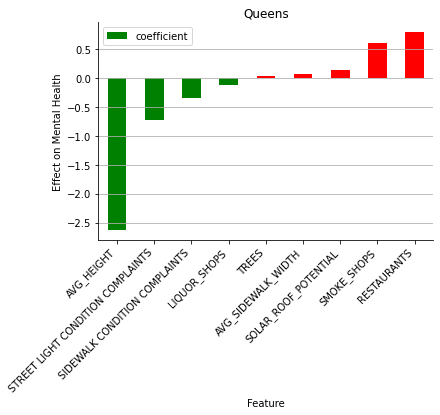

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


data2 = data3[data3['COUNTY'] == "Queens"]

X = data2[['TREES', 'LIQUOR_SHOPS', 'SMOKE_SHOPS',
           'SOLAR_ROOF_POTENTIAL', 'RESTAURANTS', 'AVG_SIDEWALK_WIDTH',
           'SIDEWALK CONDITION COMPLAINTS', 'STREET LIGHT CONDITION COMPLAINTS',
           'AVG_HEIGHT']]

y = data2['MENTAL HEALTH CALLS']

model = LinearRegression()
model.fit(X, y\
          #, sample_weight=weights\
         )

# create a dataframe of feature coefficients
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}).sort_values('coefficient')
df.columns = df.columns.str.replace('_NORMALIZED', '').str.replace('NORMALIZED_', '')

# create a color map where negative values are green and positive values are red
colors = np.where(df['coefficient']>=0, 'red', 'green')

# create a bar plot of the coefficients
ax = df.plot(x='feature', y='coefficient', kind='bar', color=colors)

# set the axis labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Effect on Mental Health')
ax.set_title('Feature Coefficients')

# rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add a horizontal grid to the plot
ax.yaxis.grid(True)
plt.title('Queens')
# display the plot
plt.show()
plt.savefig('QUEENS.jpg')

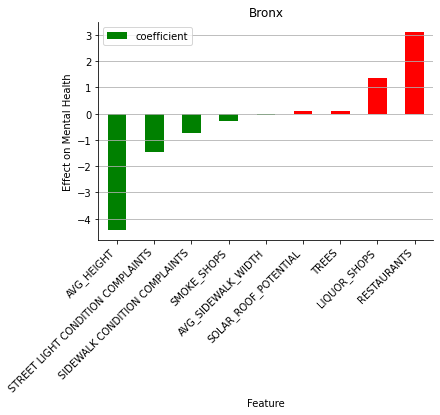

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


data2 = data3[data3['COUNTY'] == "Bronx"]

X = data2[['TREES', 'LIQUOR_SHOPS', 'SMOKE_SHOPS',
           'SOLAR_ROOF_POTENTIAL', 'RESTAURANTS', 'AVG_SIDEWALK_WIDTH',
           'SIDEWALK CONDITION COMPLAINTS', 'STREET LIGHT CONDITION COMPLAINTS',
           'AVG_HEIGHT']]

y = data2['MENTAL HEALTH CALLS']

model = LinearRegression()
model.fit(X, y\
          #, sample_weight=weights\
         )

# create a dataframe of feature coefficients
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}).sort_values('coefficient')
df.columns = df.columns.str.replace('_NORMALIZED', '').str.replace('NORMALIZED_', '')

# create a color map where negative values are green and positive values are red
colors = np.where(df['coefficient']>=0, 'red', 'green')

# create a bar plot of the coefficients
ax = df.plot(x='feature', y='coefficient', kind='bar', color=colors)

# set the axis labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Effect on Mental Health')
ax.set_title('Feature Coefficients')

# rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add a horizontal grid to the plot
ax.yaxis.grid(True)
plt.title('Bronx')
# display the plot
plt.show()
plt.savefig('Bronx.jpg')

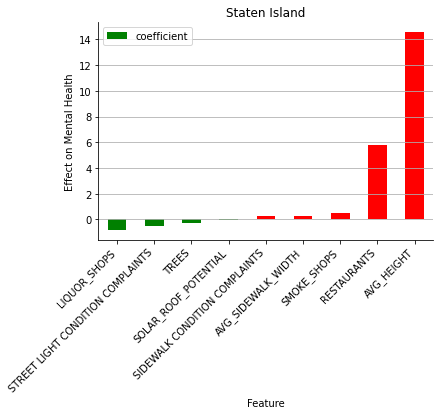

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


data2 = data3[data3['COUNTY'] == "Richmond"]

X = data2[['TREES', 'LIQUOR_SHOPS', 'SMOKE_SHOPS',
           'SOLAR_ROOF_POTENTIAL', 'RESTAURANTS', 'AVG_SIDEWALK_WIDTH',
           'SIDEWALK CONDITION COMPLAINTS', 'STREET LIGHT CONDITION COMPLAINTS',
           'AVG_HEIGHT']]

y = data2['MENTAL HEALTH CALLS']

model = LinearRegression()
model.fit(X, y\
          #, sample_weight=weights\
         )

# create a dataframe of feature coefficients
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}).sort_values('coefficient')
df.columns = df.columns.str.replace('_NORMALIZED', '').str.replace('NORMALIZED_', '')

# create a color map where negative values are green and positive values are red
colors = np.where(df['coefficient']>=0, 'red', 'green')

# create a bar plot of the coefficients
ax = df.plot(x='feature', y='coefficient', kind='bar', color=colors)

# set the axis labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Effect on Mental Health')
ax.set_title('Feature Coefficients')

# rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add a horizontal grid to the plot
ax.yaxis.grid(True)
plt.title('Staten Island')
# display the plot
plt.show()
plt.savefig('Staten Island.jpg')